In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Install necessary libraries
!pip install transformers torch torchvision torchaudio scikit-learn imblearn torch-optimizer matplotlib wordcloud nltk

# For BLEU score
!pip install nltk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.4 MB/s eta 0:00:00


In [3]:
# Check GPU availability
!nvidia-smi


Thu Nov 21 17:15:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Number of GPU:  1
GPU Name:  Tesla P100-PCIE-16GB
Using device: cuda


In [5]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Load your scraped data from the provided URL
url = "https://raw.githubusercontent.com/amanullahshah32/Review-Scraping/refs/heads/main/Dataset/cleaned_dataset.csv"
df = pd.read_csv(url)

# Check the column names to find the appropriate columns
print(df.columns)

# Drop rows where 'review_description' or 'rating' are missing
df.dropna(subset=['review_description', 'rating'], inplace=True)

# Sample 1,000 rows randomly
df = df.sample(n=1000, random_state=42)

# Shuffle the sampled dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Create a sentiment column based on rating (assuming rating scale is 1-5)
# Mapping: 1-2 -> Negative, 3 -> Neutral, 4-5 -> Positive
df['sentiment'] = df['rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['review_description'], df['sentiment'], test_size=0.2, random_state=42
)

# Convert labels to list
train_labels = train_labels.tolist()
val_labels = val_labels.tolist()

# Optional: Display the first few rows of the shuffled dataframe
print(df.head())


Index(['source', 'review_id', 'user_name', 'review_title',
       'review_description', 'rating', 'thumbs_up', 'review_date',
       'developer_response', 'developer_response_date', 'appVersion',
       'language_code', 'country_code', 'app_name'],
      dtype='object')
        source                             review_id      user_name  \
0  Google Play  fcdb40a1-5476-4e43-9734-405793f4cf15  A Google user   
1  Google Play  fc9f6420-2337-458d-9d6c-30dd6aa03202  A Google user   
2  Google Play  c9d01e10-d443-482f-a4a2-cb40f6337fab  A Google user   
3  Google Play  b7ad0a99-12e3-464f-b66e-1e837adb6620  A Google user   
4  Google Play  ec02d7d8-3c1a-417c-9b1e-c00e69097e38  A Google user   

   review_title                                 review_description  rating  \
0           NaN                                It is like a friend       5   
1           NaN                       It is very useful to me.....       4   
2           NaN  It's really good at telling me when I'm about ...  

In [6]:
from imblearn.over_sampling import RandomOverSampler

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Since train_texts is a pandas Series, we need to reshape it to a DataFrame
train_texts_df = pd.DataFrame(train_texts)

# Apply oversampling to balance the classes
train_texts_resampled, train_labels_resampled = ros.fit_resample(train_texts_df, train_labels)

# Convert the DataFrame of resampled texts back to a list
train_texts_resampled = train_texts_resampled.squeeze().tolist()

# Verify the distribution after resampling
from collections import Counter
print("Class distribution after resampling:", Counter(train_labels_resampled))


Class distribution after resampling: Counter({2: 692, 0: 692, 1: 692})


In [7]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
train_encodings = tokenizer(
    train_texts_resampled, truncation=True, padding=True, max_length=128
)
val_encodings = tokenizer(
    val_texts.tolist(), truncation=True, padding=True, max_length=128
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
import torch
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the PyTorch datasets
train_dataset = ReviewDataset(train_encodings, train_labels_resampled)
val_dataset = ReviewDataset(val_encodings, val_labels)


In [10]:
!pip install torch-optimizer --quiet


In [12]:
from transformers import BertForSequenceClassification

# Load the pre-trained BERT model for sequence classification (3 classes)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
import torch_optimizer as optim


In [14]:
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Optimizer: using AdamW with weight decay and a smaller learning rate
learning_rate = 3e-5  # You can experiment with different learning rates
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Alternatively, using AdamP for better weight decay handling
# optimizer = optim.AdamP(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Update the total number of training steps for 2 epochs
epochs = 2  # Set epoch size to 2 as per instruction
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight

# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Convert the class labels to a NumPy array
classes = np.array([0, 1, 2])

# Calculate class weights
class_weights = compute_class_weight(
    'balanced', classes=classes, y=train_labels_resampled
)

# Convert to a PyTorch tensor and move it to the appropriate device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use the weights in the loss function
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)


In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(f"Model is on device: {device}")


Model is on device: cuda


In [17]:
import time
import torch
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Initialize lists to track metrics
train_accuracies = []
val_accuracies = []
epoch_durations = []
precision_scores = []
recall_scores = []
f1_scores = []

for epoch in range(epochs):  # Training for 2 epochs
    start_time = time.time()  # Start time for the epoch

    # Training loop
    model.train()
    train_preds = []
    train_labels_epoch = []  # Track labels for each epoch
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        
        outputs = model(**batch)
        loss = loss_fn(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Track predictions and true labels to calculate training accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        train_preds.extend(predictions.cpu().numpy())
        train_labels_epoch.extend(batch['labels'].cpu().numpy())  # Update epoch-specific labels

    # Calculate training accuracy for the epoch
    train_accuracy = accuracy_score(train_labels_epoch, train_preds)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_preds = []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            val_preds.extend(predictions.cpu().numpy())

    # Calculate validation accuracy for the epoch
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_accuracy)
    
    # Calculate precision, recall, F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(
        val_labels, val_preds, average='weighted', zero_division=0
    )
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    end_time = time.time()  # End time for the epoch
    epoch_duration = end_time - start_time
    epoch_durations.append(epoch_duration)

    # Print epoch results
    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_accuracy:.4f} | "
          f"Val Acc: {val_accuracy:.4f} | Precision: {precision:.4f} | "
          f"Recall: {recall:.4f} | F1-Score: {f1:.4f} | Time: {epoch_duration:.2f} seconds")


Epoch 1/2 | Train Acc: 0.8454 | Val Acc: 0.8950 | Precision: 0.8756 | Recall: 0.8950 | F1-Score: 0.8832 | Time: 26.20 seconds
Epoch 2/2 | Train Acc: 0.9807 | Val Acc: 0.8900 | Precision: 0.8754 | Recall: 0.8900 | F1-Score: 0.8820 | Time: 25.58 seconds


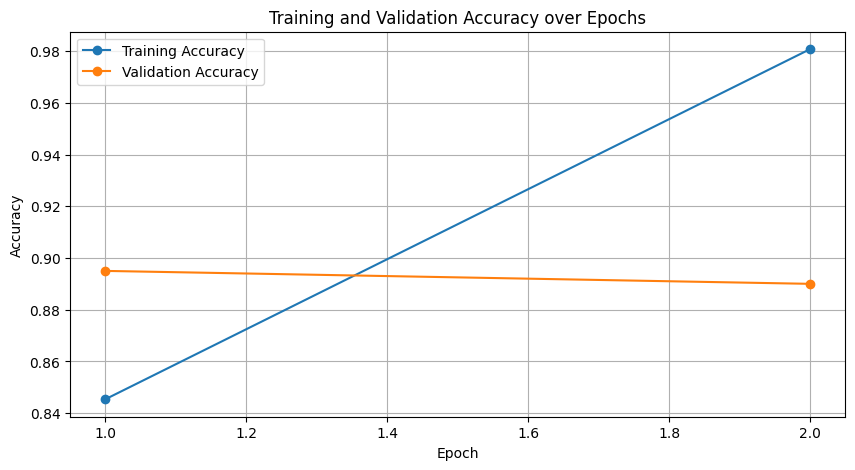

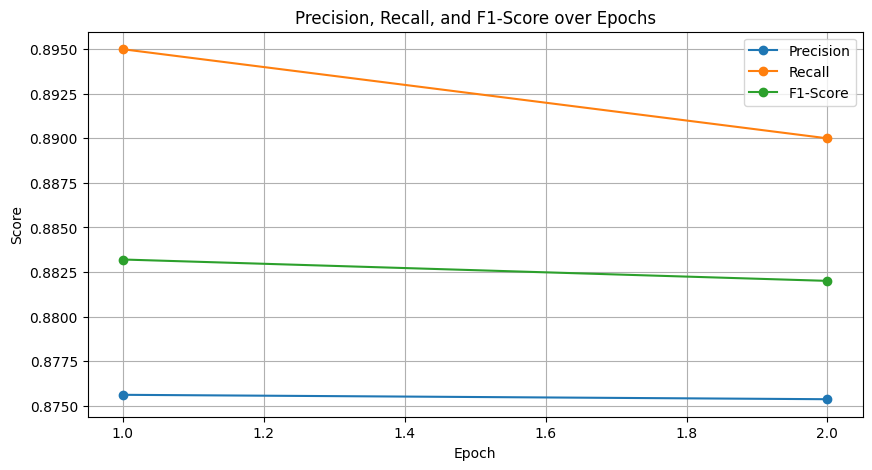

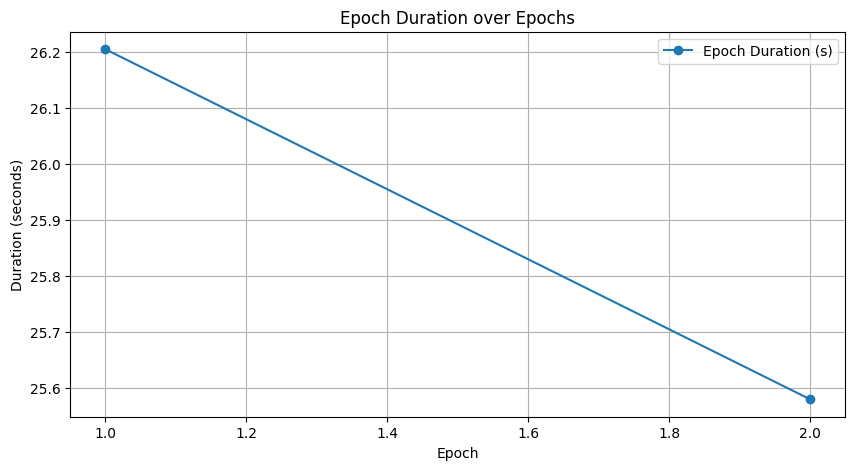

In [18]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label="Training Accuracy", marker='o')
plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot precision, recall, and F1-Score
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), precision_scores, label="Precision", marker='o')
plt.plot(range(1, epochs+1), recall_scores, label="Recall", marker='o')
plt.plot(range(1, epochs+1), f1_scores, label="F1-Score", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot epoch durations
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), epoch_durations, label="Epoch Duration (s)", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Duration (seconds)")
plt.title("Epoch Duration over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

# Download NLTK data for BLEU
nltk.download('punkt')

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_train = tfidf_vectorizer.fit_transform(train_texts_resampled)
tfidf_val = tfidf_vectorizer.transform(val_texts.tolist())

# Example: Compute BLEU score for a sample
# Note: BLEU is typically used for evaluating text generation, not classification.
# However, here's how you can compute it between true labels and predictions.

# Generate predictions on validation set
model.eval()
val_preds = []
with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        val_preds.extend(predictions.cpu().numpy())

# Compute BLEU score for each prediction vs true label (not standard usage)
# Here, we'll treat the labels as "sentences" for demonstration
smooth = SmoothingFunction().method1
bleu_scores = []
for true, pred in zip(val_labels, val_preds):
    reference = [str(true).split()]  # Reference needs to be a list of tokenized sentences
    hypothesis = str(pred).split()
    bleu = sentence_bleu(reference, hypothesis, smoothing_function=smooth)
    bleu_scores.append(bleu)

# Calculate average BLEU score
average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score on Validation Set: {average_bleu:.4f}")


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Average BLEU Score on Validation Set: 0.1583


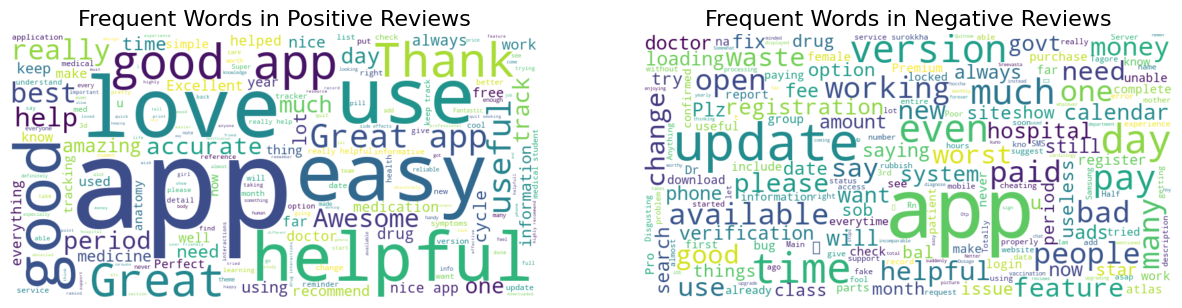

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate positive and negative reviews
positive_reviews = df[df['sentiment'] == 2]['review_description']
negative_reviews = df[df['sentiment'] == 0]['review_description']

# Join all reviews into a single string
positive_text = " ".join(review for review in positive_reviews)
negative_text = " ".join(review for review in negative_reviews)

# Generate word cloud for positive reviews
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Generate word cloud for negative reviews
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plotting the word clouds
plt.figure(figsize=(15, 7.5))

# Positive Word Cloud
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Frequent Words in Positive Reviews', fontsize=16)

# Negative Word Cloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Frequent Words in Negative Reviews', fontsize=16)

plt.show()
